# AWS Serverless Application Model (SAM)

## Basics of SAM

SAM is all about automation and in theory *no need to go to AWS console*. SAM uses a CLI and simplified templates which are extension of CloudFormation templates (basically a yaml file). It supports Lambda, API Gateway, DynamoDB, and S3, and event like StepFunctions, SNS, SQS, etc.

We'll create a Hello World example. First install it:
`pip install aws-sam-cli`. We run `sam init` and chose hello-world options.

The template is in `template.yaml` and the only required fields are transform and resources.

We then build and deploy the application. 

```bash
cd sam-app && sam build   # default name is sam-app 
sam deploy --stack-name clab-stack --s3-bucket <TEMPLATE-BUCKET-NAME> --capabilities CAPABILITY_IAM   # s3-bucket is optional, capabilities are for CloudFormation to create IAM role
```
This will build CloudFormation stack, API Gateway, Lambda, and IAM role, and create some files in S3 bucket. Lambda is a Node.js function triggered by API Gateway. 

## Full stack web application


Now we build a full stack web app, we'll have template that will create a DynamoDB table, then Lambdas which will be APIs called by API Gateway. 

## DynamoDB table

We use `AWS::Serverless::SimpleTable` resource to create DynamoDB table. 

template.yaml file
```yaml
AWSTemplateFormatVersion: '2010-09-09'
Transform: AWS::Serverless-2016-10-31
Description: >
 Infrastructure for CLAB "Building and Deploying Serverless Applications using SAM"
Resources:
  CourseTable:
    Type: AWS::Serverless::SimpleTable
    Properties:
      TableName: Courses
      PrimaryKey:
        Name: ID
        Type: Number
Outputs:
  DynamoDBTableName:
    Description: "DynamoDB Table Name"
    Value: !Ref CourseTable
```


let's add a few items:

```bash
aws dynamodb batch-write-item --request-items '{
  "Courses": [
    {"PutRequest": {"Item": {"ID": {"N": "1"}, "CourseName": {"S": "The Detailed Workings of AWS S3"}, "CourseURL": {"S": "https://www.educative.io/courses/detailed-workings-aws-s3"}, "ImageURL": {"S": "https://www.educative.io/cdn-cgi/image/format=auto,width=950,quality=75/v2api/collection/10370001/6071752037236736/image/6458556865314816"}}}},
    {"PutRequest": {"Item": {"ID": {"N": "2"}, "CourseName": {"S": "The Good Parts of AWS: Cutting Through the Clutter"}, "CourseURL": {"S": "https://www.educative.io/courses/good-parts-of-aws"}, "ImageURL": {"S": "https://www.educative.io/cdn-cgi/image/format=auto,width=950,quality=75/v2api/collection/10370001/5943367834796032/image/4534786195456000"}}}},
    {"PutRequest": {"Item": {"ID": {"N": "3"}, "CourseName": {"S": "Create an EKS Cluster and Deploy an Application"}, "CourseURL": {"S": "https://www.educative.io/cloudlabs/create-an-eks-cluster-and-deploy-an-application"}, "ImageURL": {"S": "https://www.educative.io/cdn-cgi/image/format=auto,width=750,quality=75/v2api/collection/10370001/5268241073831936/image/6466459398832128"}}}},
    {"PutRequest": {"Item": {"ID": {"N": "4"}, "CourseName": {"S": "Educative Bot with Lambda Function Fulfillment using AWS LEX"}, "CourseURL": {"S": "https://www.educative.io/cloudlabs/educative-bot-with-lambda-function-fulfillment-using-aws-lex"}, "ImageURL": {"S": "https://www.educative.io/cdn-cgi/image/format=auto,width=750,quality=75/v2api/collection/10370001/6744845660717056/image/6171933378609152"}}}}
  ]
}'
```

## Lambda functions

We use `AWS::Serverless::Function` resource to create Lambda function. 

Template.yaml

```yaml
AWSTemplateFormatVersion: '2010-09-09'
Transform: AWS::Serverless-2016-10-31
Description: >
  Lambda functions for CRUD operations
Globals:
  Function:
    Timeout: 3
    Tracing: Active
    Runtime: nodejs18.x
Resources:
  CourseTable:
    Type: AWS::Serverless::SimpleTable
    Properties:
      TableName: Courses
      PrimaryKey:
        Name: ID
        Type: Number
  GetCourses:
    Type: AWS::Serverless::Function
    Properties:
      CodeUri: functions/
      Handler: readCourses.readCourses
      Environment:
        Variables:
          COURSE_TABLE: !Ref CourseTable
      Role: 
        !Sub arn:aws:iam::${AWS::AccountId}:role/ClabLambdaRole
  InsertCourse:
    Type: AWS::Serverless::Function
    Properties:
      CodeUri: functions/
      Handler: createCourses.createCourses
      Environment:
        Variables:
          COURSE_TABLE: !Ref CourseTable
      Role: 
        !Sub arn:aws:iam::${AWS::AccountId}:role/ClabLambdaRole
  UpdateCourse:
    Type: AWS::Serverless::Function
    Properties:
      CodeUri: functions/
      Handler: updateCourses.updateCourses
      Environment:
        Variables:
          COURSE_TABLE: !Ref CourseTable
      Role: 
        !Sub arn:aws:iam::${AWS::AccountId}:role/ClabLambdaRole
  DeleteCourse:
    Type: AWS::Serverless::Function
    Properties:
      CodeUri: functions/
      Handler: deleteCourses.deleteCourses
      Environment:
        Variables:
          COURSE_TABLE: !Ref CourseTable
      Role: 
        !Sub arn:aws:iam::${AWS::AccountId}:role/ClabLambdaRole
Outputs:
  DynamoDBTableName:
    Description: "DynamoDB Table Name"
    Value: !Ref CourseTable
  GetCourses:
    Description: "GetCourses Lambda Function ARN"
    Value: !GetAtt GetCourses.Arn
  InsertCourse:
    Description: "InsertCourse Lambda Function ARN"
    Value: !GetAtt InsertCourse.Arn
  UpdateCourse:
    Description: "UpdateCourse Lambda Function ARN"
    Value: !GetAtt UpdateCourse.Arn
  DeleteCourse:
    Description: "DeleteCourse Lambda Function ARN"
    Value: !GetAtt DeleteCourse.Arn
```

A `ClabLambdaRole` role (already created) is used for all Lambda functions. It has the following policy:
```yaml
"Version": "2012-10-17",
          "Statement": [
            {
              "Action": [
                "dynamodb:Scan",
                "dynamodb:Query",
                "dynamodb:GetItem",
                "dynamodb:PutItem",
                "dynamodb:UpdateItem",
                "dynamodb:DeleteItem"
              ],
              "Effect": "Allow",
              "Resource": [
                "arn:aws:dynamodb:us-east-1:*:table/Courses"
              ]
            }
          ]
```

## APIs (via OpenAPI)

We use `AWS::Serverless::Api` resource to create REST API. An OpenAPI document defines the configurations of the API. 

`api.yaml`

```yaml
swagger: "2.0"
info:
  version: "1.0"
  title: "Courses"
basePath: "Dev/"
schemes:
- "https"
paths:
  /course:
    get:
      responses: {}
      x-amazon-apigateway-integration:
        credentials: 
           Fn::Sub: arn:aws:iam::${AWS::AccountId}:role/ClabAPIRole
        type: "aws_proxy"
        httpMethod: "POST"
        uri:
          Fn::Sub: arn:aws:apigateway:${AWS::Region}:lambda:path/2015-03-31/functions/${GetCourses.Arn}/invocations
        passthroughBehavior: "when_no_match"

    post:
      consumes:
      - "application/json"
      produces:
      - "application/json"
      responses: {}
      x-amazon-apigateway-integration:
        type: "aws_proxy"
        credentials: 
           Fn::Sub: arn:aws:iam::${AWS::AccountId}:role/ClabAPIRole
        httpMethod: "POST"
        uri:
          Fn::Sub: arn:aws:apigateway:${AWS::Region}:lambda:path/2015-03-31/functions/${InsertCourse.Arn}/invocations
        responses:
          default:
            statusCode: "200"
        passthroughBehavior: "when_no_match"

  /course/{courseId+}:
    put:
      produces:
      - "application/json"
      parameters:
      - name: "courseId"
        in: "path"
        required: true
        type: "string"
      responses: {}
      x-amazon-apigateway-integration:
        credentials: 
           Fn::Sub: arn:aws:iam::${AWS::AccountId}:role/ClabAPIRole
        httpMethod: "POST"
        uri:
          Fn::Sub: arn:aws:apigateway:${AWS::Region}:lambda:path/2015-03-31/functions/${UpdateCourse.Arn}/invocations
        responses:
          default:
            statusCode: "200"
        passthroughBehavior: "when_no_match"
        type: "aws_proxy"

    delete:
      responses: {}
      x-amazon-apigateway-integration:
        credentials: 
          Fn::Sub: arn:aws:iam::${AWS::AccountId}:role/ClabAPIRole
        type: "aws_proxy"
        httpMethod: "POST"
        uri:
          Fn::Sub: arn:aws:apigateway:${AWS::Region}:lambda:path/2015-03-31/functions/${DeleteCourse.Arn}/invocations
        passthroughBehavior: "when_no_match"
  ```

# S3 bucket to store static content

SAM doesn’t provide a resource to create an S3 bucket, we'll have to use CloudFormation but we can do this also in SAM template as it is compatible. So we add this section to the template that creates sam-web-bucket-${AWS::AccountId} bucket:

```yaml
S3Bucket:
    Type: AWS::S3::Bucket
    Properties:
      BucketName: !Sub "sam-web-bucket-${AWS::AccountId}"
      PublicAccessBlockConfiguration:
        BlockPublicAcls: false
        BlockPublicPolicy: false
        IgnorePublicAcls: false
        RestrictPublicBuckets: false
      WebsiteConfiguration:
        IndexDocument: index.html
  S3BucketPolicy:
    Type: AWS::S3::BucketPolicy
    DeletionPolicy: Retain
    Properties:
      Bucket: !Ref S3Bucket
      PolicyDocument:
        Version: '2012-10-17'
        Statement:
          - Sid: PublicReadGetObject
            Effect: Allow
            Principal: "*"
            Action: 's3:GetObject'
            Resource: !Sub "arn:aws:s3:::${S3Bucket}/*"


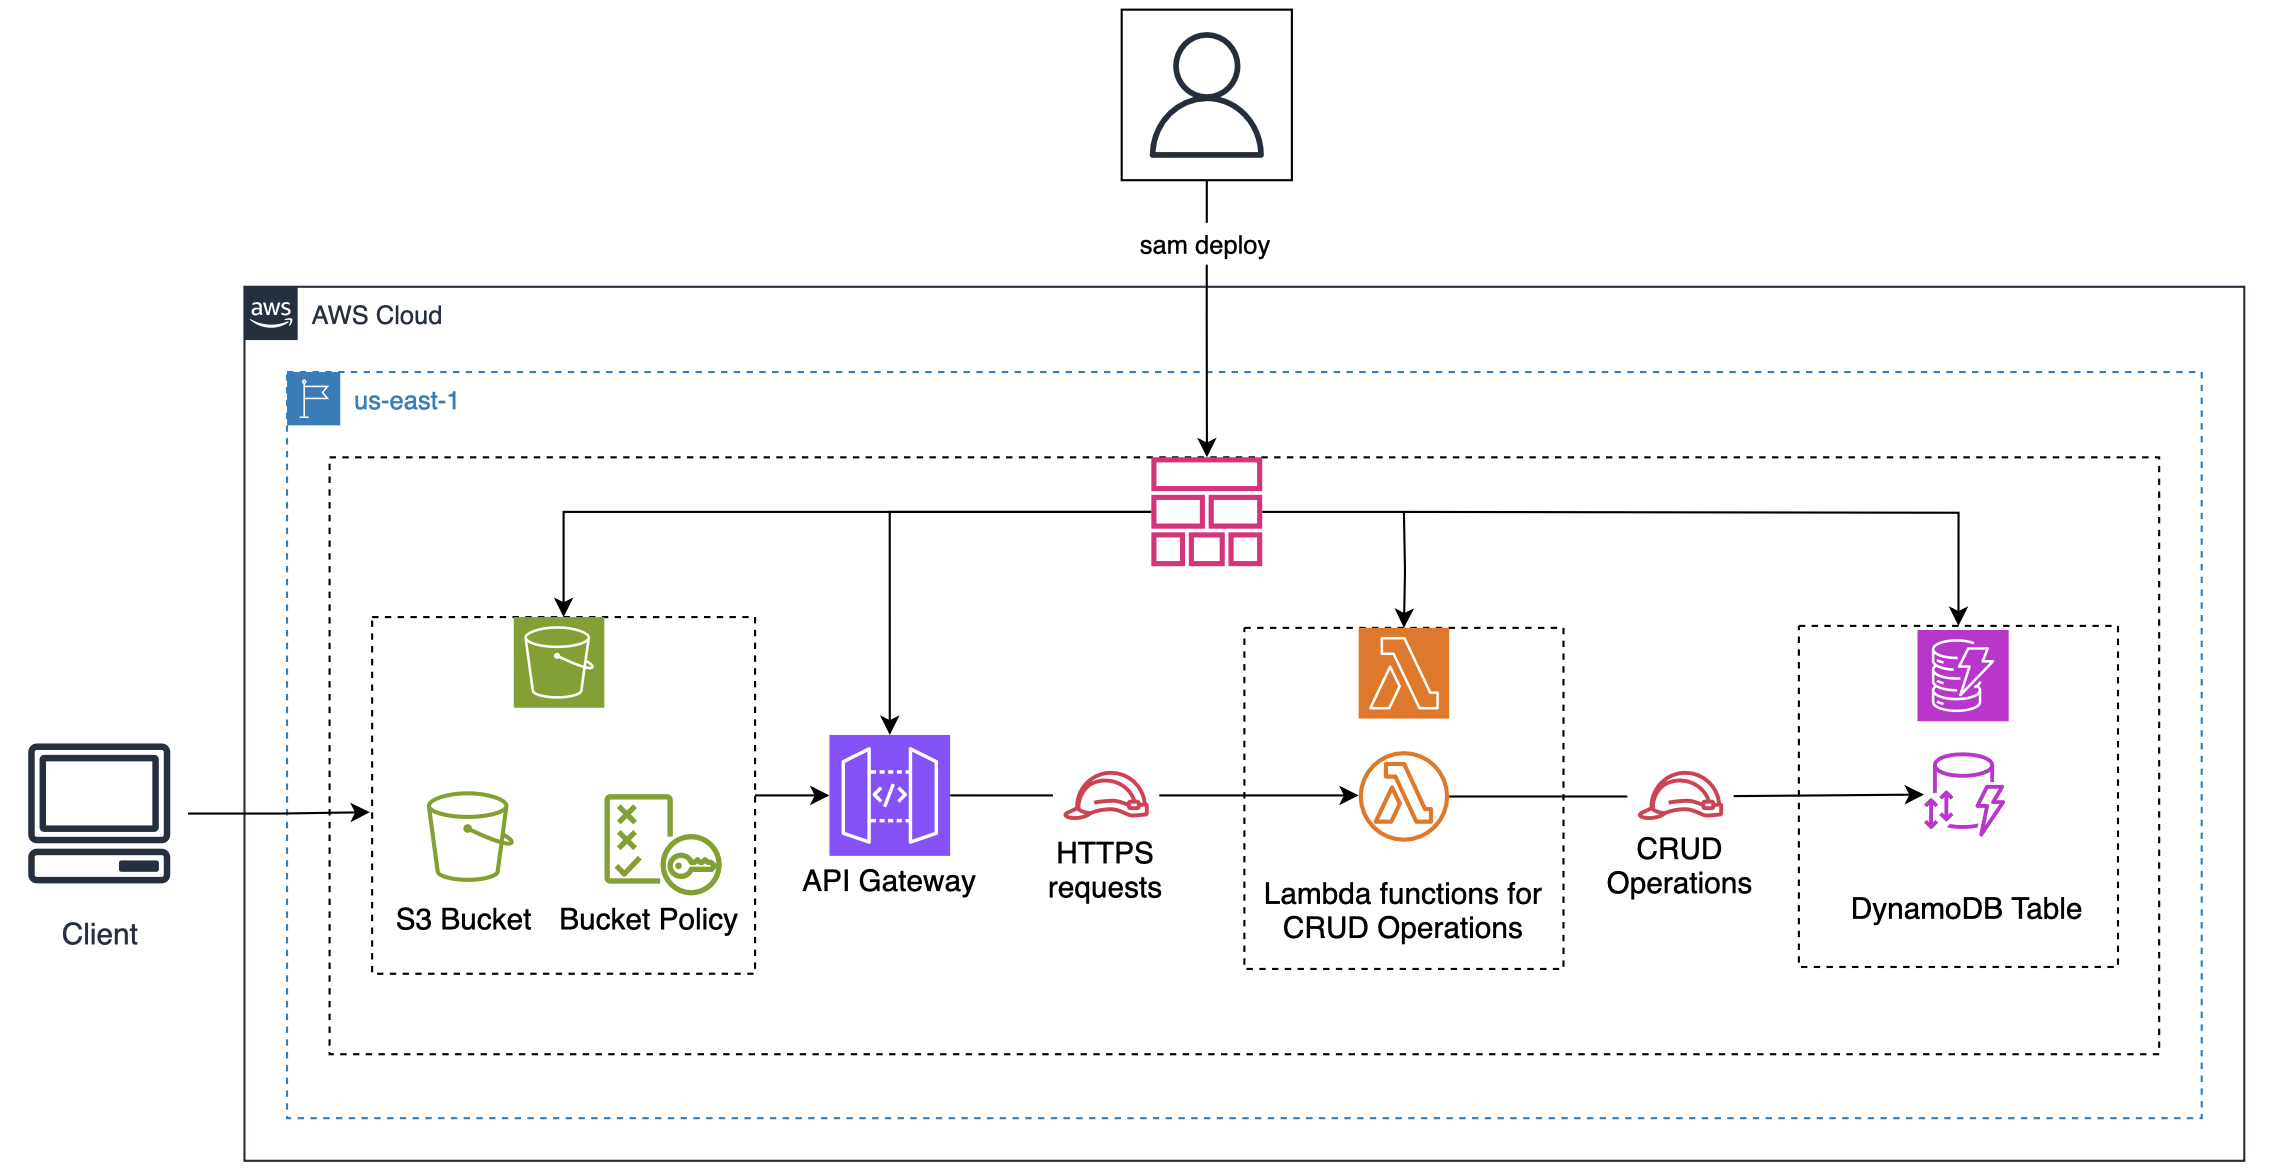